# OpenCVの基底を使った画像の変換
ここではフーリエ変換だけを扱う
    

# フーリエ変換
## 目的
このチュートリアルでは
* OpenCVを使って画像のフーリエ変換を計算する方法を学ぶ．
* NumpyのFFTを使う方法を学ぶ．
* フーリエ変換を使ったアプリケーションについて学ぶ．
* 次の関数の使い方を学ぶ : [cv2.dft()](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=cv2.dft#cv2.dft),  [cv2.idft()](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=cv2.dft#idft)


## 理論
フーリエ変換は種々のフィルタの周波数特性を解析するために使われる．画像に対しては __2次元離散フーリエ変換 (DFT)__ を使って周波数領域に変換する．高速化されたアルゴリズムである __高速フーリエ変換 (FFT)__ はDFTの計算に使いる．これらのアルゴリズムの詳細については信号処理や画像処理の教科書を参照すること． 補足資料 の章に幾つか参考文献を挙げている．

正弦波を $x(t) = A \sin(2 \pi ft)$ と書く．ここで $$f は信号の周波数を表す．この信号を周波数領域で観測すれば，周波数 f の点にspikeが見られる．離散信号を形成するために信号を標本化すると，同じ周波数領域での信号を得られるが，周波数領域での信号は $[-\pi, \pi]$ の範囲もしくは $[0,2\pi]$ の範囲での周期性を持つ信号とみなされる(N点DFTであれば $[0,N]$ の範囲)． 画像を2方向に標本化された信号とみなすことができる．横方向と縦方向にフーリエ変換を計算すれば，画像を周波数領域で表現できる．

より直観的に言うと，短時間にある正弦波信号の振幅変化が速く起こるとき、それを高周波信号と言い、振幅変化が遅ければ低周波信号と呼ぶ．全く同じ考えを画像に対して拡張する．画像中で振幅変化が急激に生じる場所はどこだろうか? それはエッジやノイズである．つまり，エッジやノイズは画像の高周波成分に対応している．振幅の変化が大きくなければ低周波成分になる( 周波数変換の直観的な説明をしている資料を [補足資料](#%E8%A3%9C%E8%B6%B3%E8%B3%87%E6%96%99) の欄に幾つか挙げておく)．

それではフーリエ変換の計算方法を見ていくことにする．

## Numpyを使ったフーリエ変換
まず初めにNumpyを使ったフーリエ変換の計算方法を見ていこう．NumpyはFFTを計算するための関数 [np.fft.fft2()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft2.html) を用意している．この関数は複素数型の配列を出力する．第1引数は入力画像をグレースケール画像として与える．第2引数は出力配列のサイズを指定するが，オプションである．指定するサイズが入力画像のサイズより大きければ入力画像はFFTの計算をする前にゼロパディングされる．入力画像のサイズより小さければ入力画像を切り取る．何も指定されなければ出力配列のサイズは入力画像のサイズと同じになる．

実際に計算をしてみると，周波数領域の原点(直流成分)が画像の左上の角に位置するようになる．直流成分を画像中心に移動させたければ，スペクトル全体を $\displaystyle \frac{N}{2}$ 両方向のずらす必要がある．この移動には [np.fft.fftshift()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftshift.html) 関数を使いる(これでより解析がしやすくなる)．一度フーリエ変換を計算すれば，スペクトルの大きさが分かる ([画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/messi5.jpg)):

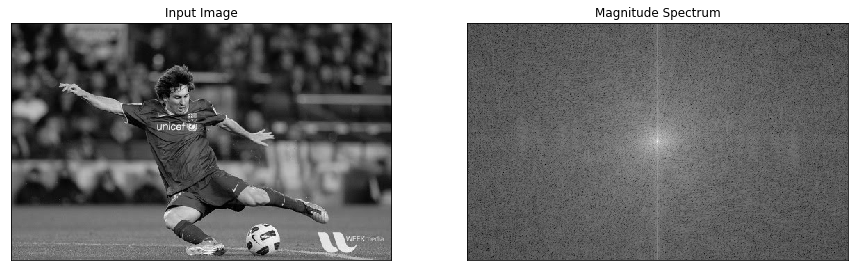

In [5]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.figure(figsize=(15,5))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

中心に白い領域が集中している事が分かる．これは画像が低周波成分をより多く含んでいることを意味する．

これでフーリエ変換を見ることができた．これによりハイパスフィルタといった周波数領域での処理ができるようになる．低周波成分に対して矩形windowを使ったマスク処理をすることによって低周波成分を取り除く事ができる．それから [np.fft.ifftshift()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.ifftshift.html) 関数を使って直流成分の位置を画像の左上に戻し、 [np.ifft2()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.ifft2.html) 関数を使って逆フーリエ変換を適用する．最終的な結果は複素数型の配列になるので，その絶対値をとる([画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/messi5.jpg)):



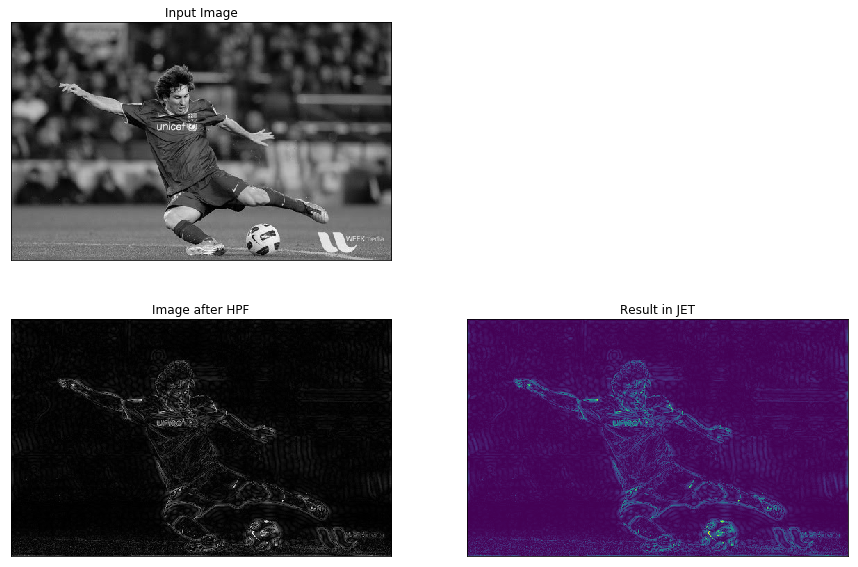

In [8]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

rows, cols = img.shape
crow,ccol = rows//2 , cols//2
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.figure(figsize=(15,10))
plt.subplot(221),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])

plt.subplot(224),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()

結果を見ると，ハイパスフィルタによって画像中のエッジが検出できていることが分かる．これは画像の勾配のチュートリアルで見た結果そのものである．画像の大半の成分が低周波領域に存在する事も分かる．とにかく，これでNumpyを使って離散フーリエ変換（DFT)，逆離散フーリエ変換（IDFT)をする方法を学んだ．次はOpenCVを使った方法を学ぶ．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/fft2.jpg)


結果を注意深く観察すると，特にJET色で描いた最後の画像を見ると，疑似輪郭(赤い矢印で示した部分である)が生じているのが分かる．波のような構造が見えるが，これを __リンギング効果__ と呼ぶ．これはマスク処理の際に矩形ウィンドウを使ったことが原因である．このマスクはフーリエ変換によってsinc関数になるためこのような結果になってしまう。そこで，矩形ウィンドウはフィルタリングには使わないのである．Gaussianウィンドウなどがより適している．

## OpenCVを使ったフーリエ変換
OpenCVには [DFTcv2.dft()](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=cv2.dft#cv2.dft) 関数と [cv2.idft()](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=cv2.idft#cv2.idft) 関数がある．Numpyと同様複素数型の配列を返し、これは2チャンネルの配列である．最初のチャンネルは結果の実部，二つ目のチャンネルが虚部に対応している．入力画像は np.float32 型に変換される必要がある．それではどのように計算するのか見てみよう([画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/messi5.jpg))．

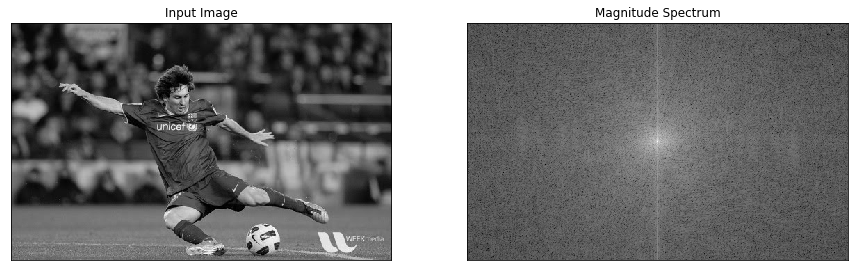

In [9]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg',0)

dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.figure(figsize=(15,10))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

<font color="blue">Note</font>:  [cv2.cartToPolar()](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=cv2.cartto#cv2.cartToPolar) 関数を使い振幅と位相の両方を取得している．

次にすべきはIDFTである．前セッションでハイパスフィルタを試したので，ここではローパスフィルタ(高周波成分の除去)を試してみよう．ローパスフィルタは画像にボケを加える．まず初めに低周波領域に高い値を持ち，高周波領域が0となるマスクを作成する ([画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/messi5.jpg))

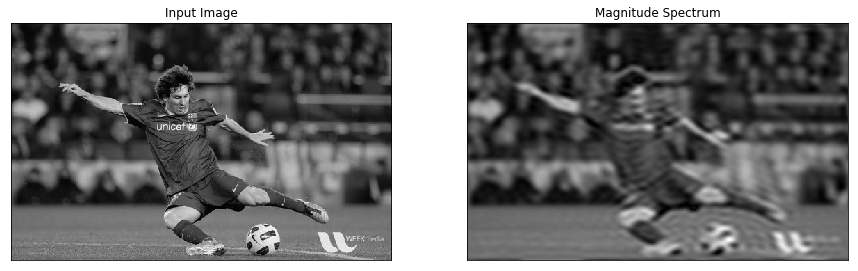

In [11]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('messi5.jpg',0)

dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

rows, cols = img.shape
crow,ccol = rows//2 , cols//2

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.figure(figsize=(15,10))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

<font color="blue">Note</font>:  よくあるように，OpenCVの関数の `cv2.dft()` と `cv2.idft()` はNumpyの処理より高速である．しかし，Numpyの関数の方が扱いやすいインターフェースを提供している．パフォーマンスについては次の章を読むこと．

## DFTのパフォーマンス最適化
DFTの計算に向いている配列のサイズがある： 2の累乗の時に最も高速に動き、サイズが2,3,5の積で表される時でも効率的に計算される．自分の実装に不安を感じた時は，DFTを適用する前に配列のサイズをゼロパディング等で最適なサイズに変更すると良いだろう．OpenCVを使うのであればゼロパディングは手動で行わなければならない．一方，NumpyならFFTを計算する時の配列のサイズを指定しさえすれば自動的にゼロパディングが行われる．

最適な配列のサイズをどのように計算すれば良いだろうか? それにはOpenCVが提供している [cv2.getOptimalDFTSize()](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=cv2.getoptimal#cv2.getOptimalDFTSize) 関数を使う．これは`cv2.dft()` と `np.fft.fft2()` 関数のどちらにも使える．IPythonのmagic commandである `%timeit` を使ってパフォーマンスを調べてみよう．

In [12]:
img = cv2.imread('messi5.jpg',0)
rows,cols = img.shape
print (rows,cols)

342 548


In [14]:
nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print ( nrows, ncols )

360 576


この結果から、配列のサイズが(342,548)から(360, 576)に変更されたのが分かる．そこで、ゼロパディングをしてからDFTをしてみよう．ゼロパディングをするには，全要素の値を0にした新しい配列を用意し，元の画像データをコピーする．

In [15]:
nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = img

ここでゼロパディングのために [cv2.copyMakeBorder()](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html?highlight=cv2.copymakeborder#cv2.copyMakeBorder) 関数を使ってもよい:

In [16]:
right = ncols - cols
bottom = nrows - rows
bordertype = cv2.BORDER_CONSTANT #just to avoid line breakup in PDF file
nimg = cv2.copyMakeBorder(img,0,bottom,0,right,bordertype, value = 0)

ようやくDFTが計算できる．Numpyの関数のパフォーマンスを比較してみまよう:

In [17]:
%timeit fft1 = np.fft.fft2(img)

45.3 ms ± 759 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit fft2 = np.fft.fft2(img,[nrows,ncols])

11.4 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


4倍高速になった．同様に、OpenCVの場合でも、パフォーマンスの計測をしみよう．

In [21]:
%timeit  dft1= cv2.dft(np.float32(img),flags=cv2.DFT_COMPLEX_OUTPUT)

3.09 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)

1.45 ms ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


こちらも4倍高速化された．OpenCVの関数を使うと、Numpyの関数を使うより3倍ほど計算が速くなるのが分かる．逆フーリエ変換でも同じテストをしてみよう．これは課題として残しておこう．

## なぜLaplacianがハイパスフィルタなのか?
ネットのフォーラムでよく似たような質問がされる：「なぜLaplacianフィルタがハイパスフィルタなのか?」「なぜSobelフィルタがハイパスフィルタなのか?」．最初の質問に対しては、フーリエ変換の観点から説明する．まずLaplacianフィルタのフーリエ変換を計算し，解析してみよう:

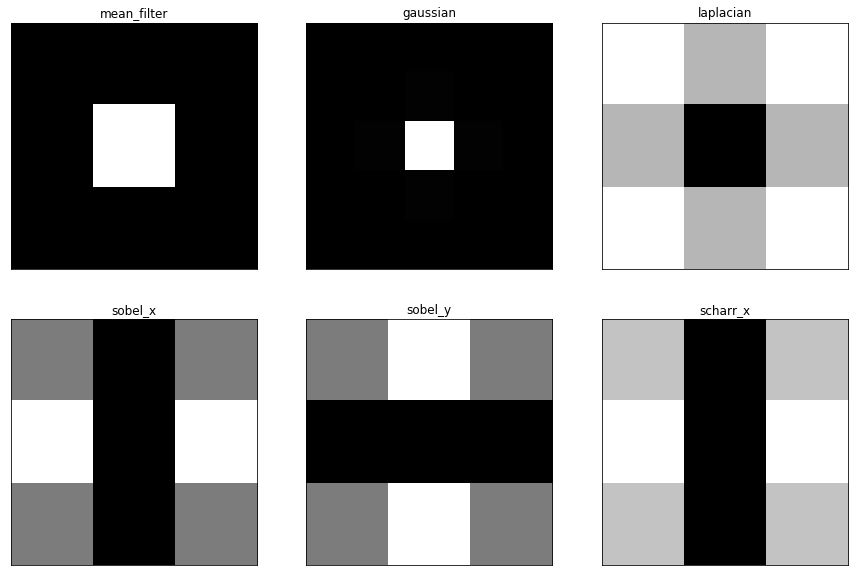

In [23]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# creating a guassian filter
x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()


結果の画像を見ると，カーネルそれぞれがどの周波数帯域をブロックするのか，どの周波数帯域を通過させるのかが分かる．ここから上記のデモで試したカーネルがハイパスフィルタなのか、それともローパスフィルタなのかが分かる．

参考のため、別な画像を示す:
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/fft5.jpg)

## 補足資料
1. [フーリエ変換の理論の直観的な説明(英語)](http://cns-alumni.bu.edu/~slehar/fourier/fourier.html) by Steven Lehar
2. [フーリエ変換(英語)](http://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm) at HIPR
3. [画像における周波数領域が何を意味するのか(英語)](http://dsp.stackexchange.com/q/1637/818)


## 目次
* [最初に戻る]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/usingOpenCV.html )
* 一つ上: OpenCVを使った画像処理
OpenCVが提供する様々な画像処理の関数について学ぶ
* 前の学習項目:  [ヒストグラム その4: ヒストグラムの逆投影法 histogramBackProjection.ipynb](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/histogramBackProjection.html)<BR>
色に基づいて領域分割するためのヒストグラム逆投影法
* 次の学習項目: [テンプレートマッチング templateMatching.ipynb ](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/templateMatching.html)<BR>
テンプレートマッチングを使った物体検出を学ぶ．